In [1]:
##
#The simple example for Neuronal network of the rhesus monkey’s motor cortex by CIC
from utils import plot_score_matrix
import torch
from CIC import CIC
import os
import other_functions as OF
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_score_matrix
import seaborn as sns

In [ ]:
## Real datasets: it recorded the single-neuron activity from the posterior parietal cortex 
# (PPC) in a rhesus monkey, which was trained to perform a flexible manual interception task.
# Three task periods were selected, touch center (TC), delay going (GO), and movement onset (MO).
# A total of 1378 correct trials were conducted, and all trials are divided into eight groups 
# according to different directions. The neuronal activities of 136 single units of each trial were recorded.
xy_dim=12
z_dim=6
hid_dim=128
weights = torch.tensor([0.35, 0.35, 0.14, 0.09,0.225,0.001,0.001])
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#The causal network reconstruction for three different task periods.
def brain_all(name):
    wdir = '/.../data/brain' #the folder location of the raw time-series data.
    raw = np.load(f'{wdir}/SpikeBin_{name}.npy')
    data_all = np.mean(raw, axis=0).T
    out_s, causal_index, Net_causal=CIC(data_all,weights,xy_dim,z_dim,hid_dim,embedding_dim=xy_dim,time_delay=1,T=1,num_epochs=30,device=device)
     
    res_dir = f'/.../brain'  #the folder location used to store the results
    np.save(f'{res_dir}/{name}_out_s.npy', out_s) #the common latent space of each pairwise variables.
    np.save(f'{res_dir}/{name}_CVS.npy', causal_index) # the CIC score for each pairwise variables.
    np.save(f'{res_dir}/{name}_Net.npy', Net_causal) #the causal network or reconstructed Neuronal network.
    print(name, 'finish_brain_all')

#The causal network reconstruction for eight different direction of each task period.
def brain_direction(name, i):
    wdir = '/.../data/brain'
    index_d = np.load(f'{wdir}/EndpointIndex.npy')
    raw = np.load(f'{wdir}/SpikeBin_{name}.npy')

    data_all = np.mean(raw[index_d == i], axis=0).T
    out_s, causal_index, Net_causal=CIC(data_all,weights,xy_dim,z_dim,hid_dim,embedding_dim=xy_dim,time_delay=1,T=1,num_epochs=30,device=device)
    
    res_dir = f'/.../brain'
    np.save(f'{res_dir}/{name}_out_s_d{i+1}.npy', out_s)
    np.save(f'{res_dir}/{name}_CVS_d{i+1}.npy', causal_index)
    np.save(f'{res_dir}/{name}_Net_d{i+1}.npy', Net_causal)
    print(name, i, 'finish_brain_direction')

In [ ]:

res_dir = f'/.../brain'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
#Inferring causal network 
periods = ['TC', 'GO', 'MO']
for i in periods:
    brain_all(i)  #Causal networks of different periods
    for j in range(8):
        brain_direction(i, j) #Causal networks of different directions

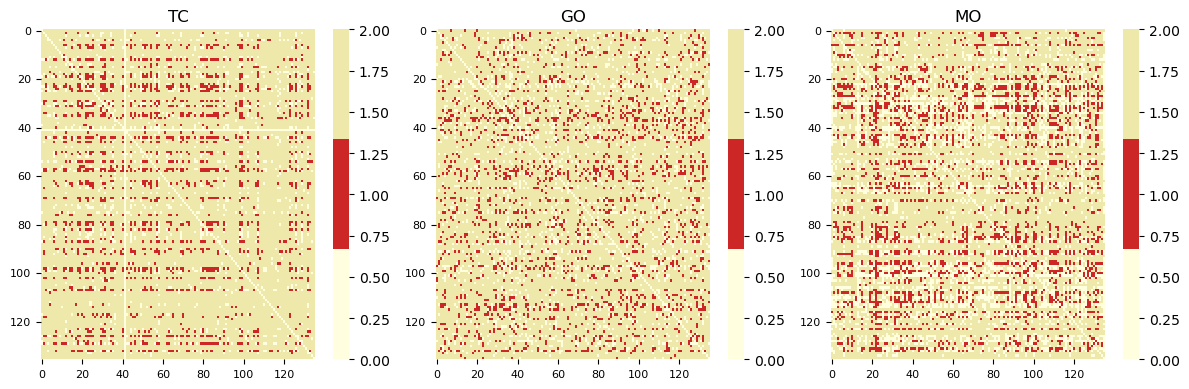

In [3]:
#Used for presenting  the causal network density
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, name in enumerate(['TC', 'GO', 'MO']):
    mat = np.load(f'{res_dir}/{name}_Net.npy')                  #"#FFF68F","#FFD700","#CD2626"
    ax[i] = plot_score_matrix(mat, annot=False, tick_bin=20, linewidths=0, vmin=0, vmax=2, cmap=sns.color_palette(["#FFFFE0","#CD2626","#EEE8AA"]),  ax=ax[i]) 
    ax[i].set_title(name)

(-0.4839129986670518,
 1.07066252374605,
 -0.6458976788725304,
 0.42933040349800305)

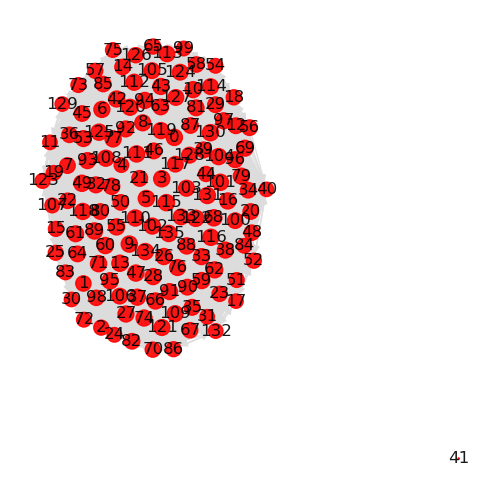

In [37]:
#Used for presenting  the causal network topology
import networkx as nx
cutoff = 1
scores = np.load(f'{res_dir}/TC_Net.npy')
adj_mat = OF.discretize_score(scores, cutoff) 
np.fill_diagonal(adj_mat, 0.)
G = nx.from_numpy_array(adj_mat, create_using=nx.DiGraph)
#pos = nx.kamada_kawai_layout(G, scale=5,  dim=2)
pos = nx.spring_layout(G, k=1, seed=1)

fig, ax = plt.subplots(figsize=(5, 5))
node_color = ['r'] * 136 
node_size = [1*d[1] + 1 for d in G.out_degree]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.9,
)
ax.margins(0.05, 0.05)
fig.tight_layout()
plt.axis("off")

Text(0, 0.5, 'Density')

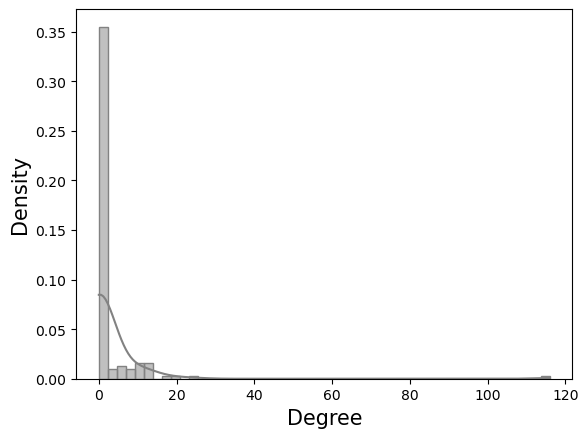

In [35]:
#Used for presenting the degrees’ distribution of causal network
od_seq = [d[1] for d in G.out_degree]
fig, ax = plt.subplots()
sns.histplot(od_seq, kde=True, bins=50, stat="density",color='#828282', edgecolor='#828282', linewidth=1, ax=ax)
ax.set_xlabel('Degree', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
#plt.xlim(0, 45)

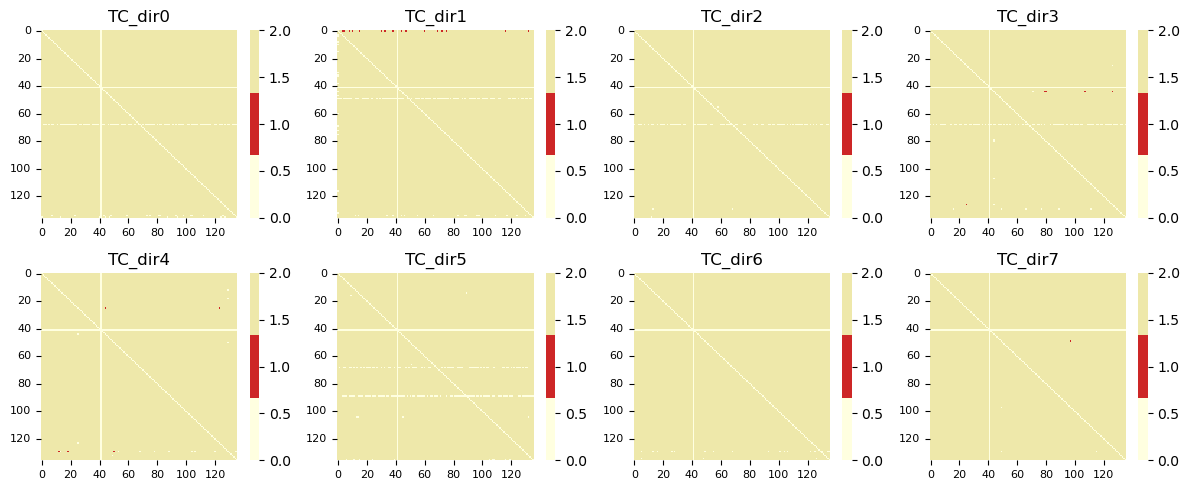

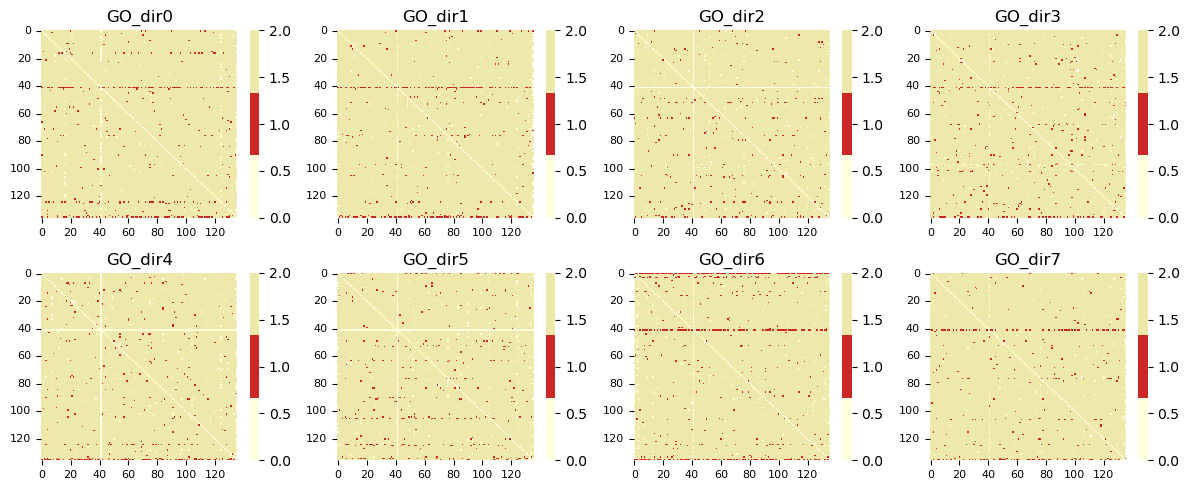

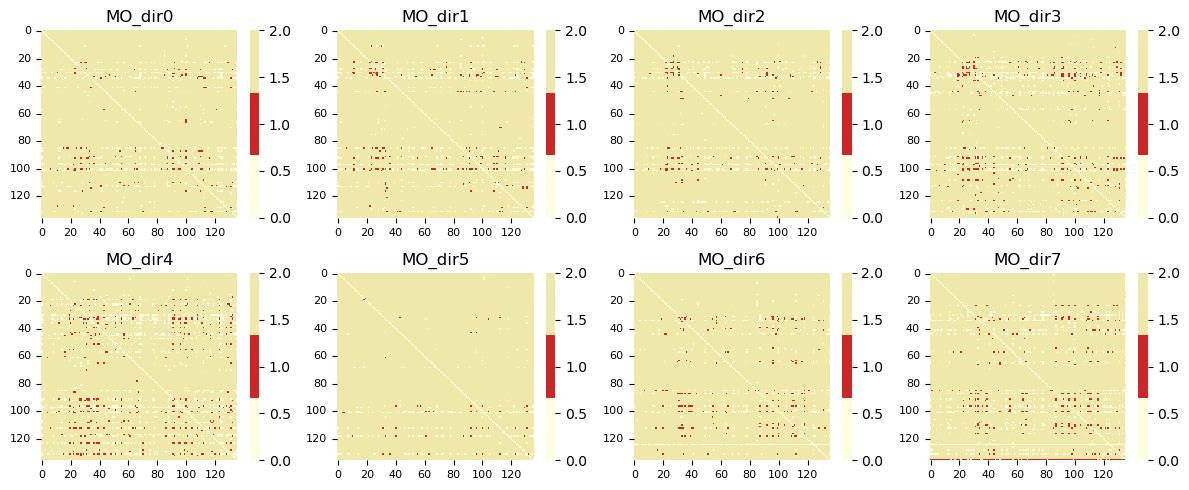

In [22]:
#Used for presenting the causal network density of different directions for each period
score_mats = []
for name in ['TC', 'GO', 'MO']:
    score_list = []
    for d in range(1, 9):
        scores = np.load(f'{res_dir}/{name}_Net_d{d}.npy')
        score_list.append(OF.skip_diag_tri(scores).ravel())
    score_mat = np.asarray(score_list)
    score_mats.append(score_mat)

for j, name in enumerate(['TC', 'GO', 'MO']):
    fig, ax = plt.subplots(2, 4, figsize=(12, 5))
    ax = ax.flatten()
    for i in range(8):
        ax[i] = plot_score_matrix(OF.score_seq_to_matrix(score_mats[j][i]), annot=False, tick_bin=20, linewidths=0, vmin=0, vmax=2, cmap=sns.color_palette(["#FFFFE0", "#CD2626","#EEE8AA"]),  ax=ax[i]) 
        ax[i].set_title(f'{name}_dir{i}')

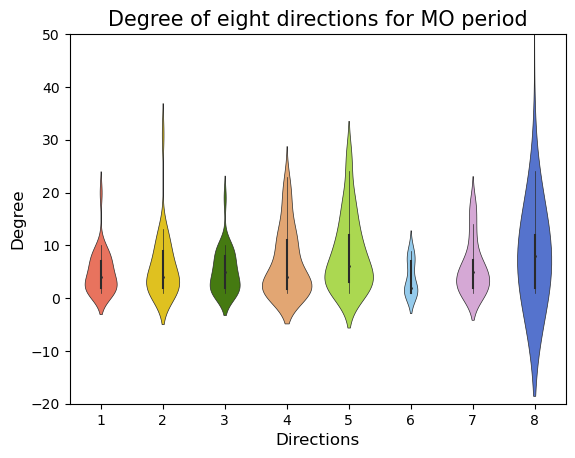

In [34]:
##
#the value of the violin diagram represents the outdegree of the neuronal network 
# in different directions, and the higher outdegrees represent the more stimulation 
# from one neuron to other neurons.
import pandas as pd
samp = torch.zeros(3,8)
for i, name in enumerate(['TC', 'GO', 'MO']):   
    for d in range(8):
        wdir = '/.../data/brain'
        index_d = np.load(f'{wdir}/EndpointIndex.npy')
        raw = np.load(f'{wdir}/SpikeBin_{name}.npy')
        samp[i,d]=len(raw[index_d == d])
N=136        
for i in range(8):
    scores = np.load(f'{res_dir}/MO_Net_d{i+1}.npy')
    scores[scores == 1] = 1
    scores[scores == 2] = 0
    G = nx.from_numpy_array(scores, create_using=nx.DiGraph)
    node_degree0 = [d[1] for d in G.out_degree]
    if i==0:
        node_degree=node_degree0
    else:
        node_degree=node_degree+node_degree0

df = pd.DataFrame({'Degree':node_degree, 'Directions': [1] * N + [2] * N+ [3] * N+ [4] * N+ [5] * N+ [6] * N+ [7] * N+ [8] * N})
df['label'] = df['Directions'].replace({1: 'D1', 2: 'D2', 3: 'D3', 4: 'D4', 5: 'D5', 6: 'D6', 7: 'D7', 8: 'D8'})
df0 = df[df['Degree'] != 0]
plt.figure()
custom_palette = ["#FF6347","#FFD700","#458B00","#F4A460","#B3EE3A","#87CEFA","#DDA0DD","#4169E1"] #"#FFC0CB","#F4A460","#FFD700","#B3EE3A","#458B00","#87CEFA","#DDA0DD"
sns.violinplot(x='Directions', y='Degree', data=df0, inner="box", linewidth=0.5, palette=custom_palette, scale='count')
plt.title('Degree of eight directions for MO period', fontsize=15)
plt.ylim([-20, 50])
#plt.xlabel('')
plt.xlabel('Directions', fontsize=12)
plt.ylabel('Degree', fontsize=12)
plt.show() 

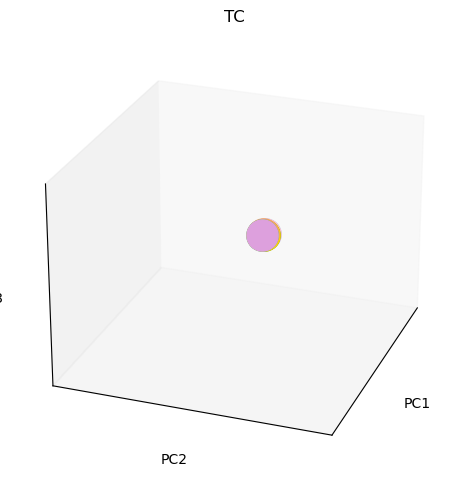

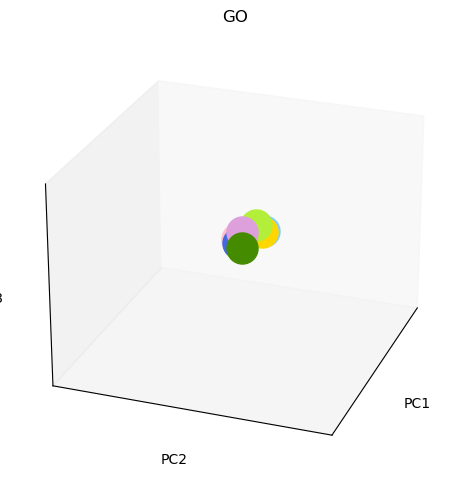

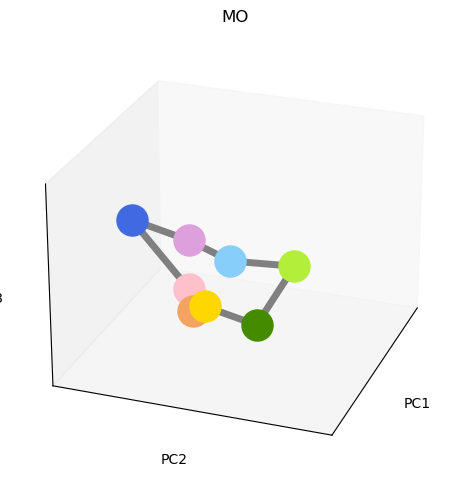

In [24]:
## Causal state space of reconstructed neuronal network
#The high-dimensional causal network is transformed into a low-dimensional causal state space.
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(np.vstack(score_mats))
pca.explained_variance_ratio_
clist = ['#FFC0CB', '#F4A460', '#FFD700', '#458B00', '#B3EE3A', '#87CEFA', '#DDA0DD', '#4169E1', '#CD5C5C']

for n, name in enumerate(['TC', 'GO', 'MO']):
    X_r = pca.transform(score_mats[n])
    X_r2 = np.vstack((X_r, X_r[:1]))
    row, col = 25, 20

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.view_init(row, col)

    for i in range(8):
        ax.scatter3D(X_r[i, 0], X_r[i, 1], X_r[i, 2], c=clist[i], label=f'D{i+1}', s=500, zorder=2)
    ax.plot3D(X_r2[:, 0], X_r2[:, 1], X_r2[:, 2], c='gray', zorder=1, lw=5)
    
    lim = 60
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'{name}')
    fig.tight_layout()